# Clinical Trials by Volume of Publications

This notebook shows how use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) in order to get a list of clinical trials records and then sort them by the total number of publications they cite.

In [2]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 25, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).

In [3]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *

import os, sys, time, json
from tqdm.notebook import tqdm 
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


## Query for Clinical Trials

In [4]:
q = """search clinical_trials where category_rcdc.name="Multiple Sclerosis" 
        and active_years=[2017, 2018, 2019] 
        return clinical_trials[basics+publication_ids]"""

In [5]:
df = dsl.query_iterative(q).as_dataframe()
df.head()

Starting iteration with limit=1000 skip=0 ...
0-1000 / 3353 (3.08s)
1000-2000 / 3353 (3.93s)
2000-3000 / 3353 (2.83s)
3000-3353 / 3353 (1.22s)
===
Records extracted: 3353


id                                      investigators  \
0  UMIN000045085  [[Mostafa  Sarabzadeh, , Public Contact, Natio...   
1  UMIN000044955  [[Seina  Toneri, , Public Contact, Mebix, Inc....   
2  UMIN000043910  [[Hiroaki  Yokote, , Public Contact, Nitobe Me...   
3  UMIN000038903  [[Takami  Ishizuka, , Public Contact, National...   
4  UMIN000038431  [[Mohammad  Bayattork, , Public Contact, Unive...   

                                               title active_years  \
0  Neurophysiological effects of a high-speed neu...          NaN   
1  A multicentre, retrospective study in patients...          NaN   
2  Association between brain atrophy and intestin...          NaN   
3  Efficacy and Safety of OCH-NCNP1 in patients w...          NaN   
4  Twelve weeks of Pilates training improved func...          NaN   

  publication_ids  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

## Counting publications per clinical trial

Before we can count publications, we should ensure that all the values are 'countable'. So we have to transform all None values in `publication_ids` into empty lists first.

In [6]:
# replace empty values with empty lists so that they can be counted
for row in df.loc[df.publication_ids.isnull(), 'publication_ids'].index:
    df.at[row, 'publication_ids'] = []

Now it's ok to count publications

In [7]:
# create new column
df['pubs_tot'] = df['publication_ids'].apply(lambda x: len(x))
# sort 
df.sort_values("pubs_tot", ascending=False, inplace=True)
df.head(5)

id                                      investigators  \
521   NCT04073940  [[Citlali Lopez-Ortiz, PhD, MA, Contact, Unive...   
648   NCT03782246  [[Dawn Ehde, PhD, Principal Investigator, Univ...   
327   NCT04550455  [[Keith R Edwards, MD, Study Director, MS Cent...   
1313  NCT02104661  [[Gavin Givannoni, , Principal Investigator, Q...   
947   NCT03004079  [[Myla Goldman, MD, Principal Investigator, Un...   

                                                  title  \
521   Exploration of Brain Changes Due to a Targeted...   
648   Mindfulness-based Cognitive Therapy and Cognit...   
327   A Prospective Biomarker Study in Active Second...   
1313  OxCarbazepine as a Neuroprotective Agent in MS...   
947   Assessment of the Clinical Importance of Insul...   

                              active_years  \
521                     [2019, 2020, 2021]   
648         [2018, 2019, 2020, 2021, 2022]   
327   [2020, 2021, 2022, 2023, 2024, 2025]   
1313        [2014, 2015, 2016, 2017, 2018]   
947         [2016, 2017, 2018, 2019, 2020]   

                                        publication_ids  pubs_tot  
521   [pub.1100827489, pub.1035450339, pub.103700030...        99  
648   [pub.1059401852, pub.1001854818, pub.102868830...        72  
327   [pub.1104144237, pub.1122095683, pub.101866541...        52  
1313  [pub.1035408940, pub.1011294811, pub.100257806...        48  
947   [pub.1001068458, pub.1013002909, pub.103549213...        46

A simple data visualization

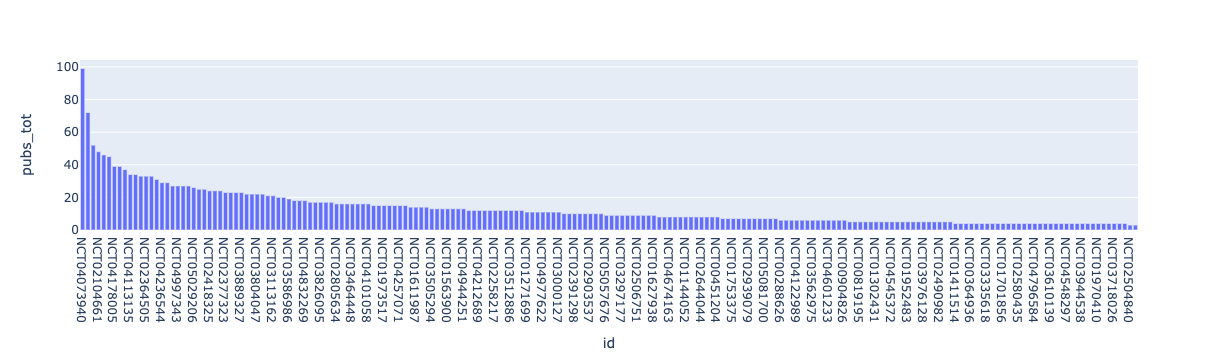

In [8]:
px.bar(df[:200], x="id", y="pubs_tot", 
      hover_name="title", hover_data=["active_years"])